In [ ]:
import os 

import pandas as pd
import numpy as np
import scanpy as sc


from SURE import DensityFlow
from SURE.flow import plot_quiver, VectorFieldEval
from SURE.perturb import LabelMatrix


import torch
torch.set_float32_matmul_precision("high")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 仅显示GPU 0

np.random.seed(42) 

import matplotlib.pyplot as plt 
%matplotlib inline

pert_col = 'gene'
control_label = 'NT'
loss_func = 'poisson'

In [2]:
adata_train = sc.read_h5ad('jiang2025_train.h5ad')

In [3]:
sc.pp.normalize_total(adata_train)
sc.pp.log1p(adata_train)

In [4]:
adata_test = sc.read_h5ad('jiang2025_test.h5ad')

sc.pp.normalize_total(adata_test)
sc.pp.log1p(adata_test)

In [ ]:
xs = adata_train.X 

lb = LabelMatrix()
us = lb.fit_transform(adata_train.obs[pert_col], control_label=control_label)
ln = lb.labels_

us.shape


(95585, 52)

In [6]:
model = DensityFlow.load_model(f'benchmark_densityflow_{loss_func}_model.pth')

Model loaded from benchmark_densityflow_poisson_model.pth
🧬 DensityFlow Initialized:
   - Codebook size: 15
   - Latent Dimension: 50
   - Gene Dimension: 33525
   - Hidden Dimensions: [512]
   - Device: cuda:0
   - Parameters: 37,309,940


### Compute basal embedding for training data

In [7]:
zs = model.get_basal_embedding(xs)

100%|██████████| 94/94 [00:00<00:00, 227.29batch/s]


In [8]:
from sklearn.decomposition import PCA 

pca_model = PCA(n_components=2)
adata_train.obsm['X_pca'] = pca_model.fit_transform(zs)

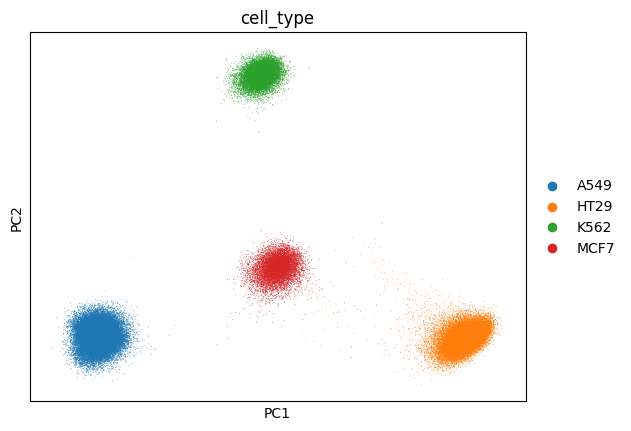

In [9]:
sc.pl.pca(adata_train, color='cell_type')

In [10]:
colormap = dict(zip(adata_train.obs['cell_type'].cat.categories, adata_train.uns['cell_type_colors']))
colormap

{'A549': '#1f77b4', 'HT29': '#ff7f0e', 'K562': '#2ca02c', 'MCF7': '#d62728'}

### Compute displacement vectors

In [12]:
adata_control = adata_train[adata_train.obs[pert_col]==control_label].copy()

In [ ]:
pert_gene = 'SMAD4'
#pert_gene = 'KRAS'
#pert_gene = 'SMURF1'


subset_idx = np.where(adata_train.obs[pert_col].isin([control_label]))[0]
subset_xs = xs[subset_idx]
subset_zs = zs[subset_idx]

In [74]:
pert_idx = int(np.where(ln==pert_gene)[0])
pert_ps = np.ones([subset_zs.shape[0],1])
dzs = model.get_cell_shift(subset_xs, pert_idx, pert_ps, show_progress=False)

### Plot displacement vectors for training data

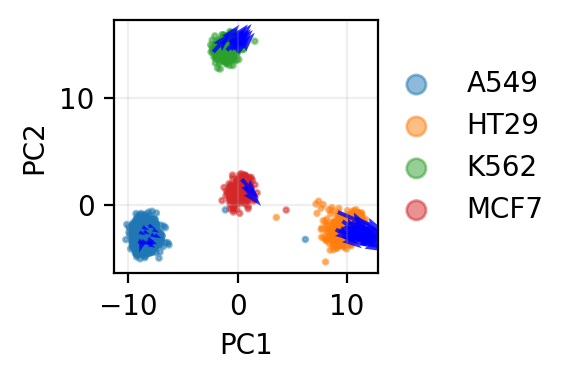

In [75]:
z_2d, _, dz_2d = plot_quiver(subset_zs, dzs, subsample=50, method='pca', figsize=(3,2), arrow_scale=1, arrow_width=0.015, no_title=True,
                             color_by=adata_control.obs['cell_type'], colormap=colormap)


In [76]:
dz_2d = pca_model.transform(subset_zs+dzs) - pca_model.transform(subset_zs)
tmp = sc.AnnData(dz_2d, obs=adata_train[subset_idx].obs)
tmp = tmp[tmp.obs['cell_type']=='MCF7']
VectorFieldEval().movement_energy(tmp.X)

{'total_energy': np.float64(673.6037316918373),
 'mean_energy': np.float64(2.7052358702483428),
 'energy_std': np.float64(0.11994801863602875)}

### Compute displacement vector for HAP1

#### Compute displacement vectors for HAP1 control cells

In [ ]:
adata_test_ctrl = adata_test[adata_test.obs[pert_col]==control_label].copy()
zs_test_ctrl = model.get_basal_embedding(adata_test_ctrl.X, show_progress=False)
zs_test_ctrl_shift = model.get_cell_shift(adata_test_ctrl.X, pert_idx, np.ones([adata_test_ctrl.shape[0],1]), soft_assign=True, show_progress=False)

# map to pca space
pos_test_ctrl = pca_model.transform(zs_test_ctrl)
pos_test_ctrl_shift = pca_model.transform(zs_test_ctrl+zs_test_ctrl_shift) - pos_test_ctrl

#### Compute PCA positions for perturbed HAP1 cells

In [ ]:
adata_test_pert = adata_test[adata_test.obs[pert_col]==pert_gene].copy()
zs_test_pert_basal = model.get_basal_embedding(adata_test_pert.X, show_progress=False)
zs_test_pert_shift = model.get_cell_shift(adata_test_pert.X, pert_idx, np.ones([adata_test_pert.shape[0],1]), show_progress=False)

# map to pca space
zs_test_pert = zs_test_pert_basal + zs_test_pert_shift
pos_test_pert = pca_model.transform(zs_test_pert)

#### Plot displacement vectors for HAP1 cells

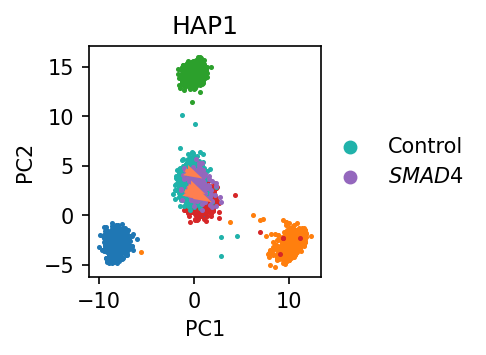

In [85]:
point_size = 2
unique_labels = adata_train.obs['cell_type'].unique()


plt.figure(figsize=(2,2), dpi=150)

for celltype in unique_labels:
    pos = adata_train[adata_train.obs['cell_type']==celltype].obsm['X_pca']
    ind = np.arange(pos.shape[0])
    if ind[-1]>1000:
        ind = np.random.choice(ind, size=1000)
    plt.scatter(pos[ind,0], pos[ind,1], 
                       c=colormap[celltype], alpha=1, s=point_size)

plt.scatter(pos_test_ctrl[:,0], pos_test_ctrl[:,1], 
                       c='lightseagreen', alpha=1, s=point_size, label='Control')
plt.scatter(pos_test_pert[:,0], pos_test_pert[:,1], 
                       c='#9467BD', alpha=1, s=point_size, label=f'${pert_gene}$')

ix = np.random.choice(pos_test_ctrl.shape[0], size=5)
plt.quiver(pos_test_ctrl[ix, 0], pos_test_ctrl[ix, 1],
                      pos_test_ctrl_shift[ix, 0], pos_test_ctrl_shift[ix, 1],
                      angles='xy', scale_units='xy', scale=1/3,
                      color='coral', width=0.02, alpha=1)

plt.legend(
        ncol = max(1, len(unique_labels) // 8),
        bbox_to_anchor=(1.00, 0.5),  # 图外右侧中间
        loc='center left',            # 锚点在左侧中间
        borderaxespad=0.0,            # 与图的间距
        frameon=False,                 # 显示边框
        fancybox=False,                # 圆角
        shadow=False,                  # 阴影
        #handletextpad=0.5,           # 点与文本间距
        markerscale=min(2*point_size,4)           # 关键：调整图例中点的大小（2倍）
        )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('HAP1')
plt.show()

In [80]:
VectorFieldEval().movement_energy(pos_test_ctrl_shift)

{'total_energy': np.float64(468.6520145088434),
 'mean_energy': np.float64(0.3151661160113271),
 'energy_std': np.float64(0.43844146690001956)}